**Load python libraries**

In [1]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import os.path
import xarray as xr
import pandas as pd
import numpy as np
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from IPython.display import Image, display
from dask.distributed import Client, progress
from glob import glob
import colorsys
from matplotlib.colors import LinearSegmentedColormap # Linear interpolation for color maps
from shapely.geometry import Point
from descartes import PolygonPatch

import sys
sys.path.append('../')
from modules.GOESR_functions import goes_lat_lon_reproj
from modules.plotter import loadCPT

#### Load NOAA NEXRAD L3 Hail Data

In [2]:
## NOAA SWDI Hail Locations 6 March 2019 ##

## location and name of txt file
filename = '/home/sbarc/students/nash/data/NOAA_SWDI/swdiws_nx3hail_all_20190306_bbox_-131_31_-116_41.csv'
# filename = '/home/sbarc/students/nash/data/NOAA_SWDI/noaa_swdi_hail_030602019_retrieved03102020.csv'
df = pd.read_csv(filename, header=0, parse_dates=['ZTIME'], skipfooter=3, engine='python')
df = df.replace(-999, np.NaN)
x_hail = df.LON
y_hail = df.LAT
df['MAXSIZE'] = df['MAXSIZE']*25.4 ## convert from inches to mm
# df

print('Average hail size:', df.MAXSIZE.mean(), 'mm')
print('Max hail size:', df.MAXSIZE.max(), 'mm')

Average hail size: 13.548815566836103 mm
Max hail size: 44.449999999999996 mm


In [3]:
df

ZTIME WSR_ID CELL_ID  PROB  SEVPROB  MAXSIZE     LAT  \
0    2019-03-06 00:55:35+00:00   KVBX      H0   NaN      NaN      NaN  33.306   
1    2019-03-06 00:59:47+00:00   KVBX      T9   NaN      NaN      NaN  33.010   
2    2019-03-06 00:59:47+00:00   KVBX      H0   NaN      NaN      NaN  33.359   
3    2019-03-06 01:03:59+00:00   KVBX      H0   NaN      NaN      NaN  33.401   
4    2019-03-06 01:08:10+00:00   KVBX      E2   NaN      NaN      NaN  33.099   
5    2019-03-06 01:08:10+00:00   KVBX      H0   NaN      NaN      NaN  33.474   
6    2019-03-06 01:12:22+00:00   KVBX      E2   NaN      NaN      NaN  33.188   
7    2019-03-06 01:12:22+00:00   KVBX      H0   NaN      NaN      NaN  33.525   
8    2019-03-06 01:16:33+00:00   KVBX      E2   NaN      NaN      NaN  33.227   
9    2019-03-06 01:16:33+00:00   KVBX      H0   NaN      NaN      NaN  33.567   
10   2019-03-06 01:24:57+00:00   KVBX      W2  30.0      0.0    12.70  33.240   
11   2019-03-06 01:29:09+00:00   KVBX      W2  20.0      0.0    12.70  33.279   
12   2019-03-06 01:30:02+00:00   KVTX      U4   NaN      NaN      NaN  33.644   
13   2019-03-06 01:30:06+00:00   KMUX      C0   NaN      NaN      NaN  35.181   
14   2019-03-06 01:33:06+00:00   KVBX      W2  20.0      0.0    12.70  33.304   
15   2019-03-06 01:33:06+00:00   KVBX      L2  10.0      0.0    12.70  35.219   
16   2019-03-06 01:33:33+00:00   KHNX      W7  20.0      0.0    12.70  35.221   
17   2019-03-06 01:35:03+00:00   KVTX      X4   NaN      NaN      NaN  33.355   
18   2019-03-06 01:35:03+00:00   KVTX      U4   NaN      NaN      NaN  33.710   
19   2019-03-06 01:36:10+00:00   KMUX      C0   NaN      NaN      NaN  35.270   
20   2019-03-06 01:37:04+00:00   KVBX      H0  80.0     10.0    12.70  33.846   
21   2019-03-06 01:37:04+00:00   KVBX      L2  10.0      0.0    12.70  35.273   
22   2019-03-06 01:38:24+00:00   KHNX      W7  40.0      0.0    12.70  35.282   
23   2019-03-06 01:40:05+00:00   KVTX      X4   NaN      NaN      NaN  33.388   
24   2019-03-06 01:40:05+00:00   KVTX      U4   NaN      NaN      NaN  33.773   
25   2019-03-06 01:40:48+00:00   KVBX      H0  90.0     20.0    12.70  33.884   
26   2019-03-06 01:40:48+00:00   KVBX      L2  20.0      0.0    12.70  35.321   
27   2019-03-06 01:42:20+00:00   KMUX      C0   NaN      NaN      NaN  35.326   
28   2019-03-06 01:43:35+00:00   KHNX      W7  30.0      0.0    12.70  35.344   
29   2019-03-06 01:44:32+00:00   KVBX      G2   NaN      NaN      NaN  33.313   
...                        ...    ...     ...   ...      ...      ...     ...   
1346 2019-03-06 23:50:09+00:00   KDAX      A7  20.0      0.0    12.70  38.464   
1347 2019-03-06 23:50:09+00:00   KDAX      U6  90.0     40.0    12.70  40.109   
1348 2019-03-06 23:51:45+00:00   KHNX      H3  10.0      0.0    12.70  36.270   
1349 2019-03-06 23:51:45+00:00   KHNX      X3  40.0     10.0    12.70  36.575   
1350 2019-03-06 23:51:45+00:00   KHNX      X2  90.0     70.0    12.70  37.662   
1351 2019-03-06 23:51:45+00:00   KHNX      Z1  80.0     40.0    12.70  37.781   
1352 2019-03-06 23:51:45+00:00   KHNX      B1  50.0     20.0    12.70  38.061   
1353 2019-03-06 23:52:19+00:00   KBHX      P5  60.0     10.0    12.70  40.129   
1354 2019-03-06 23:52:33+00:00   KMUX      A2  80.0     30.0    12.70  37.815   
1355 2019-03-06 23:52:33+00:00   KMUX      H1  60.0      0.0    12.70  38.076   
1356 2019-03-06 23:52:33+00:00   KMUX      N2  20.0      0.0    12.70  38.076   
1357 2019-03-06 23:52:37+00:00   KRGX      L0  80.0     20.0    12.70  40.331   
1358 2019-03-06 23:53:11+00:00   KDAX      X6  90.0     50.0    19.05  37.689   
1359 2019-03-06 23:53:11+00:00   KDAX      V8  70.0      0.0    12.70  37.799   
1360 2019-03-06 23:53:11+00:00   KDAX      H6  10.0      0.0    12.70  38.062   
1361 2019-03-06 23:53:11+00:00   KDAX      A7  20.0      0.0    12.70  38.511   
1362 2019-03-06 23:53:11+00:00   KDAX      U6  90.0     40.0    12.70  40.109   
1363 2019-03-06 23:54:32+00:00   KVTX      F0  30.0     

#### Load GOES-R CMI Brightness

In [13]:
filepath = '/home/sbarc/students/nash/data/GOES17_ABI_L2_CMI13/'
filename = 'OR_ABI-L2-CMIPC-M3C13_G17_s20190631802189_e20190631804573_c20190631805015.nc'

ds = xr.open_dataset(filepath+filename)
ds.t.long_name

'J2000 epoch mid-point between the start and end image scan in seconds'

In [4]:
# filename_pattern = '/home/sbarc/students/nash/data/GOES17_ABI_L2_CMI13/6-hours/OR_ABI-L2-CM*.nc'
filename_pattern = '/home/sbarc/students/nash/data/GOES17_ABI_L2_CMI13/OR_ABI-L2-CM*.nc'

GOES_files = glob(filename_pattern) # search files 
GOES_files.sort()
DS2 = xr.open_mfdataset(GOES_files, concat_dim='t')

lats, lons = goes_lat_lon_reproj(DS2)
# print test coordinates
print('{} N, {} W'.format(lats[200,300],abs(lons[200,300])))

# put reprojected GOES HT data into new dataset
DS_goes2 = xr.Dataset({'CMI': (['time', 'y', 'x'], DS2.CMI.values)},
                     coords={'time': DS2.t.values,
                            'lat': (['y', 'x'], lats),
                            'lon': (['y', 'x'], lons)})
DS_goes2

44.93265151977539 N, 163.857177734375 W


<xarray.Dataset>
Dimensions:  (time: 640, x: 2500, y: 1500)
Coordinates:
  * time     (time) datetime64[ns] 2019-03-04T18:03:38.180727936 ... 2019-03-05T20:12:43.218150016
    lat      (y, x) float32 53.500195 53.493004 ... 14.804746 14.805193
    lon      (y, x) float32 -184.37672 -184.31046 ... -112.452446 -112.430595
Dimensions without coordinates: x, y
Data variables:
    CMI      (time, y, x) float32 259.9686 254.31491 ... 296.53333 296.4719

In [15]:
## need to sort by time because filenames are sorted by start time of scan
## time of each file is centered between start and end time
DS_goes = DS_goes2.sortby(DS_goes2.time)
DS_goes.time.values

array(['2019-03-04T18:03:38.180727936', '2019-03-04T18:08:38.175056000',
       '2019-03-04T18:13:35.170685952', '2019-03-04T18:18:38.170178048',
       '2019-03-04T18:23:38.176542976', '2019-03-04T18:28:35.164685056',
       '2019-03-04T18:33:38.182075008', '2019-03-04T18:38:38.171576064',
       '2019-03-04T18:43:35.158156928', '2019-03-04T18:48:38.164489984',
       '2019-03-04T18:53:38.170892928', '2019-03-04T18:58:35.169028992',
       '2019-03-04T19:03:38.180395008', '2019-03-04T19:08:38.202707968',
       '2019-03-04T19:13:35.170350976', '2019-03-04T19:18:38.162308992',
       '2019-03-04T19:23:38.163686016', '2019-03-04T19:28:35.172833024',
       '2019-03-04T19:33:38.192214912', '2019-03-04T19:38:38.175672064',
       '2019-03-04T19:43:35.163607936', '2019-03-04T19:48:38.170864000',
       '2019-03-04T19:53:38.158097024', '2019-03-04T19:58:35.164825984',
       '2019-03-04T20:03:38.169971968', '2019-03-04T20:08:38.171412992',
       '2019-03-04T20:13:35.168683008', '2019-03-04

In [16]:
# resample to 6-hourly means
DS_goes_resample = DS_goes.resample(time='6H').mean('time')

In [17]:
DS_goes_resample

<xarray.Dataset>
Dimensions:  (time: 9, x: 2500, y: 1500)
Coordinates:
  * time     (time) datetime64[ns] 2019-03-04T18:00:00 ... 2019-03-06T18:00:00
    lat      (y, x) float32 53.500195 53.493004 ... 14.804746 14.805193
    lon      (y, x) float32 -184.37672 -184.31046 ... -112.452446 -112.430595
Dimensions without coordinates: x, y
Data variables:
    CMI      (time, y, x) float32 263.15814 262.09088 ... 295.53815 295.44427

In [ ]:
#greater than the start date and smaller than the end date & In Cloud
time_mask = (df['ZTIME'] > DS.time_coverage_start) & (df['ZTIME'] <= DS.time_coverage_end)

hail_df = df.loc[time_mask]
hail_df

./figures/fS6.png


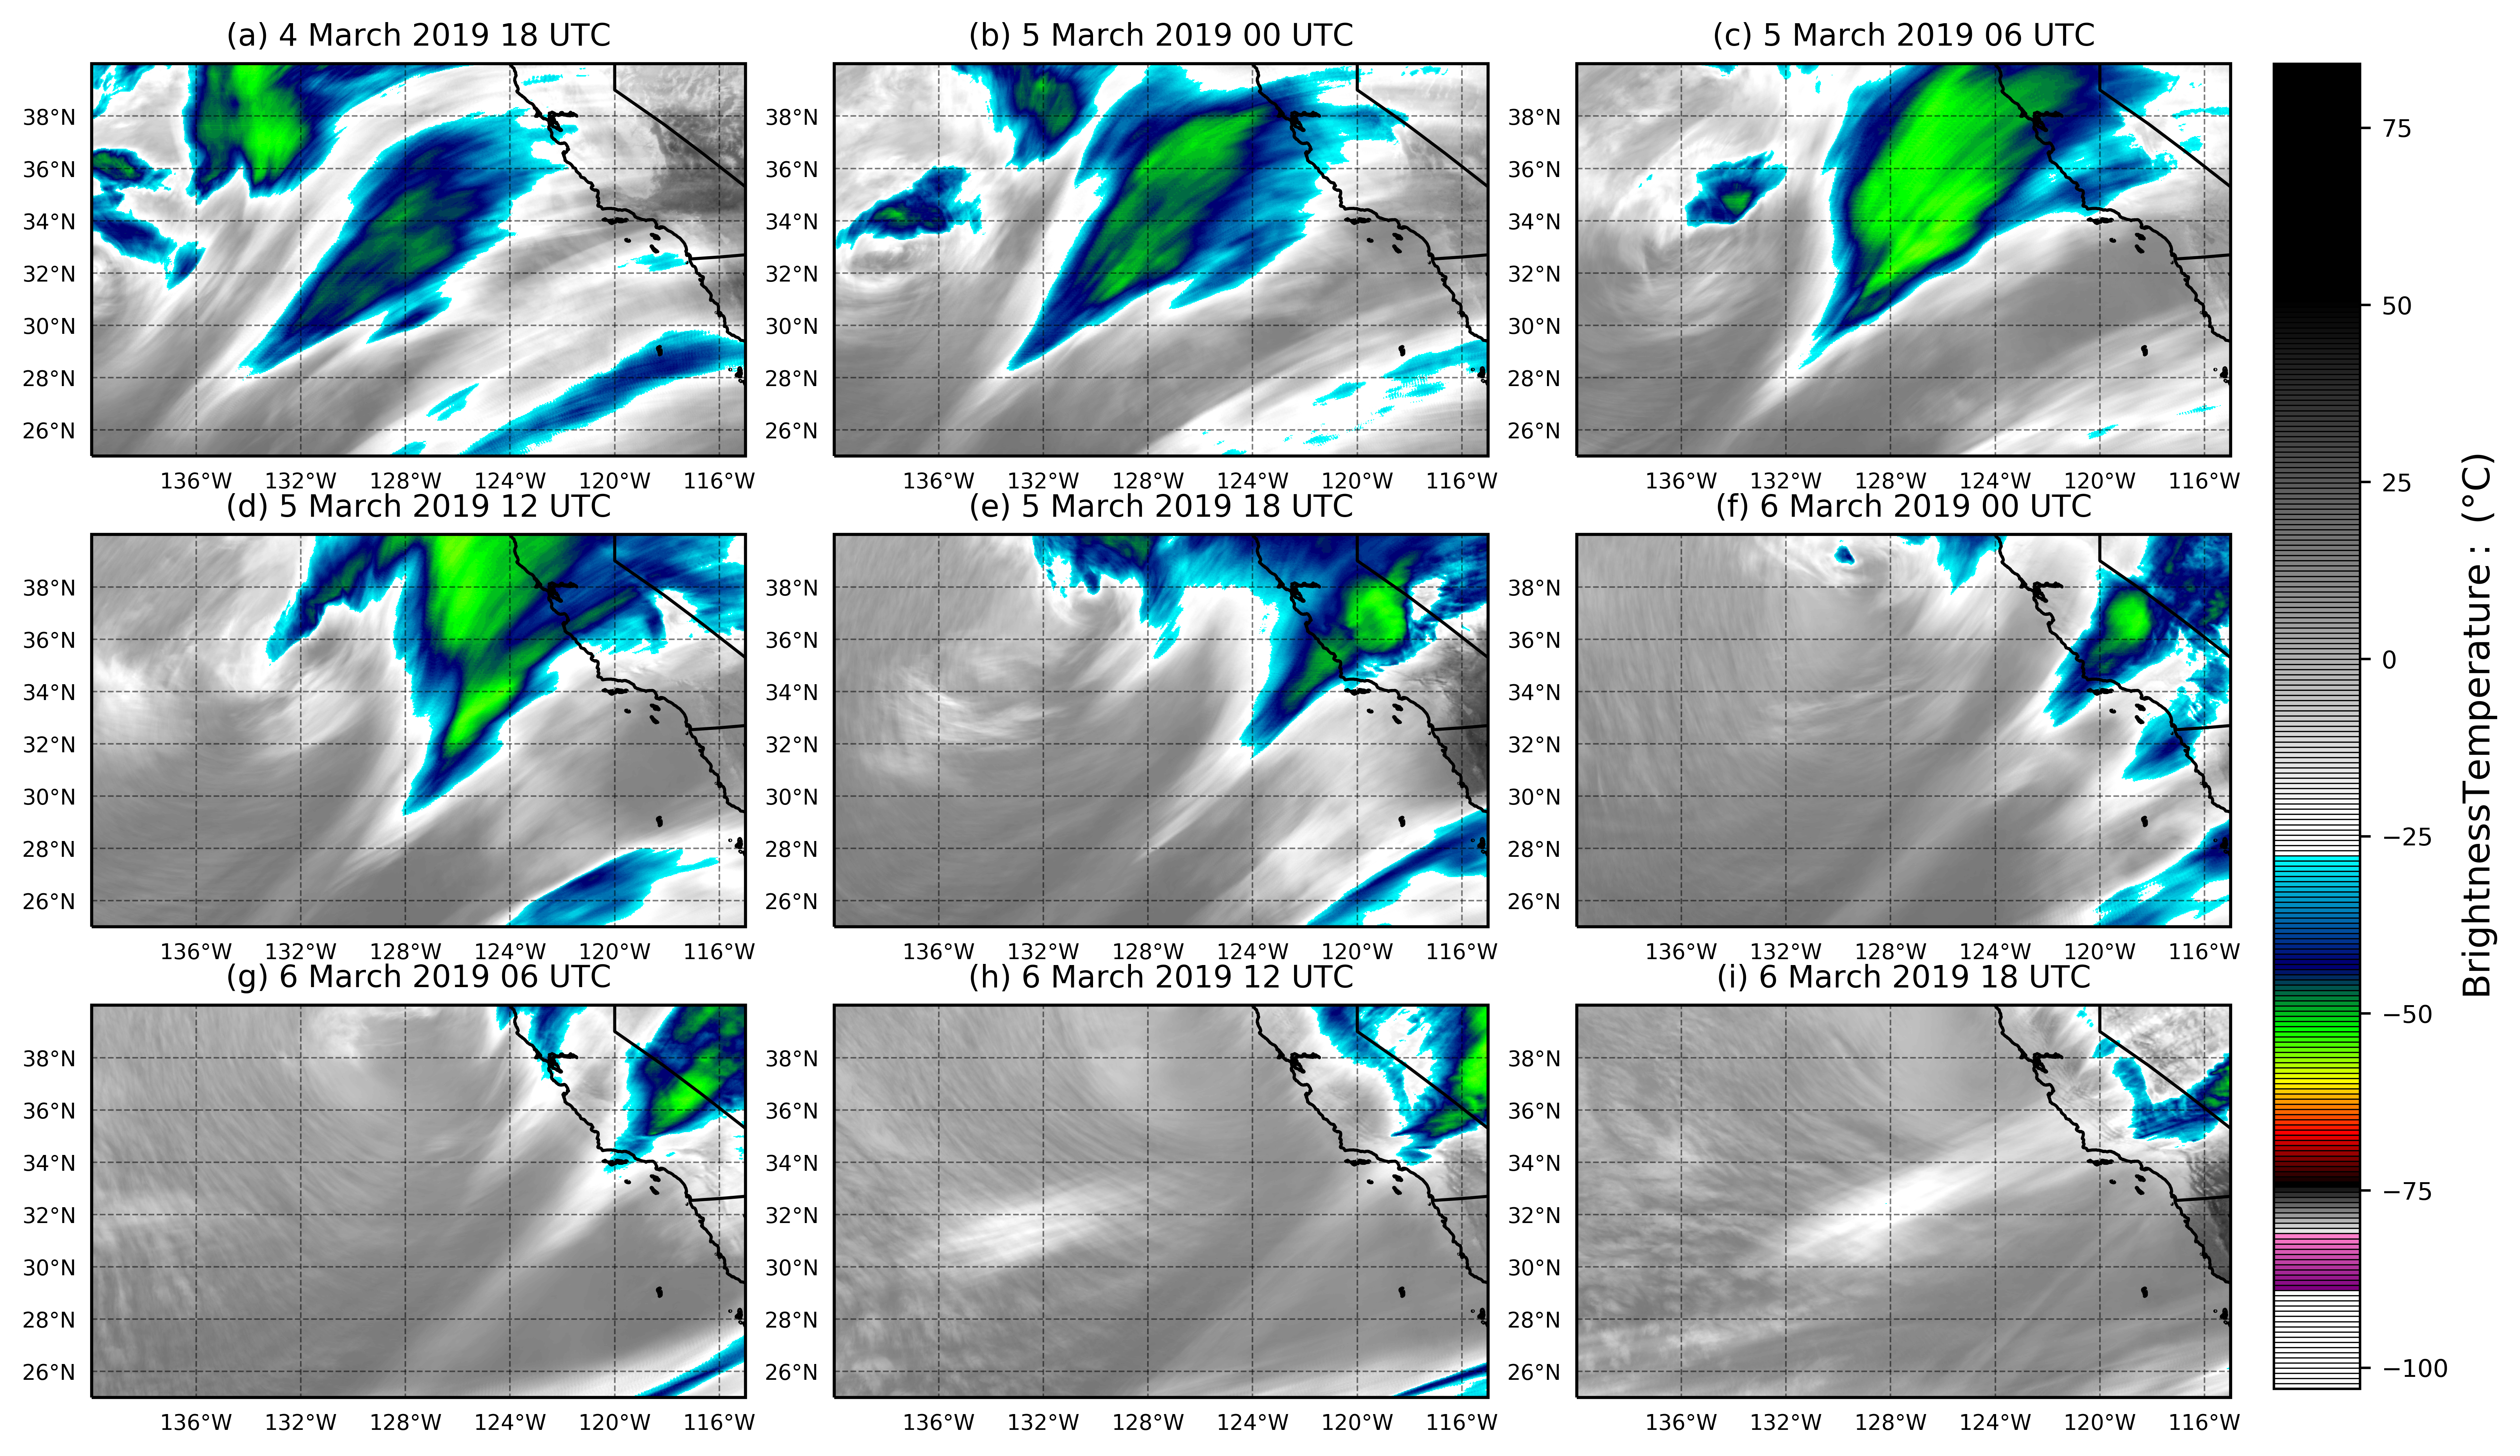

<Figure size 7800x4800 with 0 Axes>

In [19]:
# Converts a CPT file to be used in Python
cpt = loadCPT('/home/sbarc/students/nash/data/Colortables/IR4AVHRR6.cpt')

fig = plt.figure(figsize=(13., 8.0))
fig.dpi = 600
fname = './figures/fS6'
fmt = 'png'
results = DS_goes_resample.CMI - 273.15 ## Convert to Celsius
lats = DS_goes_resample.lat
lons = DS_goes_resample.lon

# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

subtitles = ['(a) 4 March 2019 18 UTC', 
             '(b) 5 March 2019 00 UTC', '(c) 5 March 2019 06 UTC', '(d) 5 March 2019 12 UTC',
             '(e) 5 March 2019 18 UTC',
            '(f) 6 March 2019 00 UTC', '(g) 6 March 2019 06 UTC', '(h) 6 March 2019 12 UTC',
             '(i) 6 March 2019 18 UTC']
# ext = (-138., -118.0, 24.0, 44.0)
ext = [-115.0, -140.0, 25.0, 40.0]
clevs = np.arange(0, 16000, 1000)
clevs_thick = np.arange(0, 13000, 1000)
clevs_fl = np.arange(0, 5250, 250)

for i in np.arange(len(results)):
    ax = plt.subplot(3, 3, i+1, projection=mapcrs)
    ax.set_extent(ext, crs=mapcrs)
#     cf = ax.contourf(DS_goes2.lon, DS_goes2.lat, results[i], transform=datacrs,
#                        cmap='jet', levels=clevs)
    
    cf = ax.pcolormesh(lons, lats, results[i],
                        transform=datacrs, cmap=cpt, vmin=-103, vmax=84)

    
#     ## Add hail points
#     ic_point = ax.plot(subic_df.longitude, subic_df.latitude, marker='o', 
#                        alpha=0.5, color='white', markersize=5,
#                        linestyle='None',
#                        transform=ccrs.PlateCarree())

    ax.coastlines(linewidths=1.0, resolution='10m')
    ax.add_feature(states_provinces, edgecolor='k')
    ax.add_feature(cfeature.BORDERS)
    ax.set_title(subtitles[i], fontsize=10)
    ## Add in meridian and parallels
    gl = ax.gridlines(crs=mapcrs, draw_labels=True,
                  linewidth=.5, color='black', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator(np.arange(-140., -110., 4))
    gl.ylocator = mticker.FixedLocator(np.arange(24, 44, 2))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 7}
    gl.ylabel_style = {'size': 7}

# # # add colorbar [left, bottom, width, height]
ax2 = fig.add_axes([0.9, 0.13, 0.03, 0.75])
cbar = fig.colorbar(cf, cax=ax2, drawedges=True, 
                    orientation='vertical', extendfrac='auto')
cbar.ax.tick_params(labelsize=8)
cbar.set_label('$\mathrm{Brightness Temperature :\ (\degree C)}$', fontsize=12)

plt.subplots_adjust(hspace=0.2, wspace=0.003)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()


plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))